# Лабораторна робота: Множинна лінійна регресія з нуля

## Мета
Реалізувати алгоритм множинної лінійної регресії з нуля за допомогою методу градієнтного спуску. Провести повний аналіз якості моделі, включаючи перевірку всіх шести класичних припущень МНК.

## Постановка задачі
**Дані**: Успішність студентів  
**Цільова змінна**: Performance Index (неперервна величина)  
**Модель**: $y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + ... + \beta_m x_{im} + \varepsilon_i$  
**Завдання**: Знайти вектор параметрів $\beta$, який мінімізує MSE  
**Метод**: Градієнтний спуск

## 1. Імпорт бібліотек

In [1]:
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.stats.stattools import durbin_watson

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Налаштування для кращого відображення
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.set_printoptions(precision=4, suppress=True)

print("Всі бібліотеки успішно імпортовані!")

Всі бібліотеки успішно імпортовані!


## 2. Завантаження та первинний огляд даних

In [2]:
# Завантаження датасету
df = pd.read_csv('Student_Performance.csv')

print("=" * 60)
print("ОГЛЯД ДАНИХ")
print("=" * 60)
print(f"\nРозмір датасету: {df.shape[0]} рядків, {df.shape[1]} стовпців\n")

# Перші рядки
print("Перші 5 рядків:")
print(df.head())

# Інформація про типи даних
print("\n" + "=" * 60)
print("ІНФОРМАЦІЯ ПРО ДАНІ")
print("=" * 60)
df.info()

ОГЛЯД ДАНИХ

Розмір датасету: 10000 рядків, 6 стовпців

Перші 5 рядків:
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  

ІНФОРМАЦІЯ ПРО ДАНІ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 colum

In [3]:
# Базова статистика
print("=" * 60)
print("ОПИСОВА СТАТИСТИКА")
print("=" * 60)
print(df.describe())

ОПИСОВА СТАТИСТИКА
       Hours Studied  Previous Scores  Sleep Hours  \
count     10000.0000       10000.0000   10000.0000   
mean          4.9929          69.4457       6.5306   
std           2.5893          17.3432       1.6959   
min           1.0000          40.0000       4.0000   
25%           3.0000          54.0000       5.0000   
50%           5.0000          69.0000       7.0000   
75%           7.0000          85.0000       8.0000   
max           9.0000          99.0000       9.0000   

       Sample Question Papers Practiced  Performance Index  
count                        10000.0000         10000.0000  
mean                             4.5833            55.2248  
std                              2.8673            19.2126  
min                              0.0000            10.0000  
25%                              2.0000            40.0000  
50%                              5.0000            55.0000  
75%                              7.0000            71.0000  
max   

## 3. Розвідковий аналіз даних (EDA)

In [4]:
# Перевірка пропущених значень
print("=" * 60)
print("ПРОПУЩЕНІ ЗНАЧЕННЯ")
print("=" * 60)
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nЗагальна кількість пропущених значень: {missing_values.sum()}")

ПРОПУЩЕНІ ЗНАЧЕННЯ
Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

Загальна кількість пропущених значень: 0


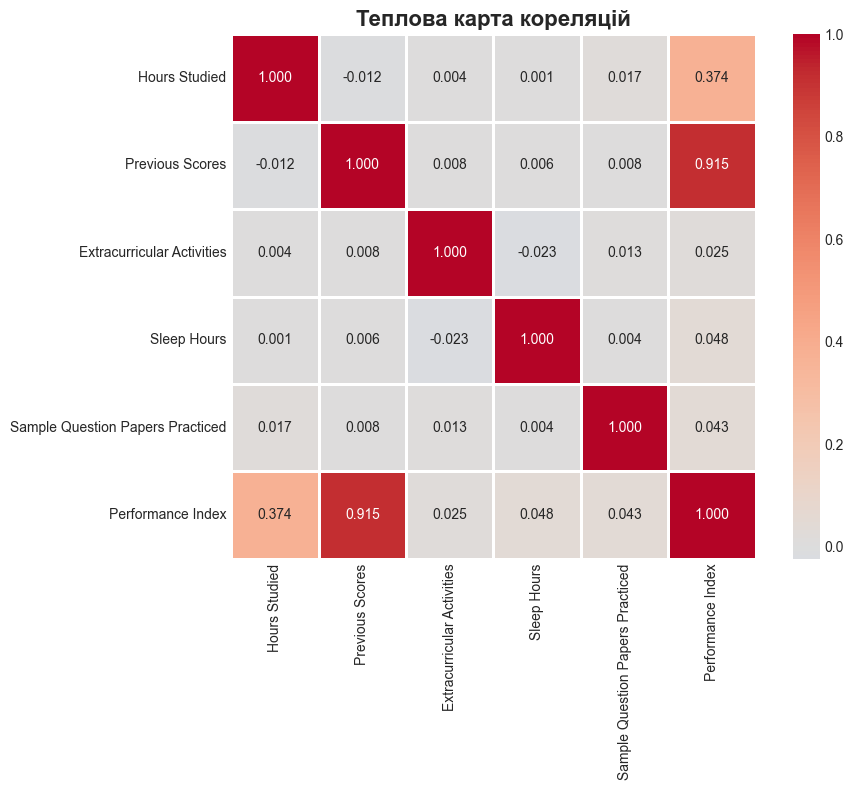


Кореляція з цільовою змінною (Performance Index):
Performance Index                   1.0000
Previous Scores                     0.9152
Hours Studied                       0.3737
Sleep Hours                         0.0481
Sample Question Papers Practiced    0.0433
Extracurricular Activities          0.0245
Name: Performance Index, dtype: float64


In [5]:
# Теплова карта кореляцій для числових змінних
plt.figure(figsize=(10, 8))

# Створюємо копію для кореляції (конвертуємо категоріальні в числові тимчасово)
df_corr = df.copy()
df_corr['Extracurricular Activities'] = df_corr['Extracurricular Activities'].map({'No': 0, 'Yes': 1})

# Обчислення кореляційної матриці
corr_matrix = df_corr.corr()

# Побудова теплової карти
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', linewidths=1, square=True)
plt.title('Теплова карта кореляцій', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nКореляція з цільовою змінною (Performance Index):")
print(corr_matrix['Performance Index'].sort_values(ascending=False))

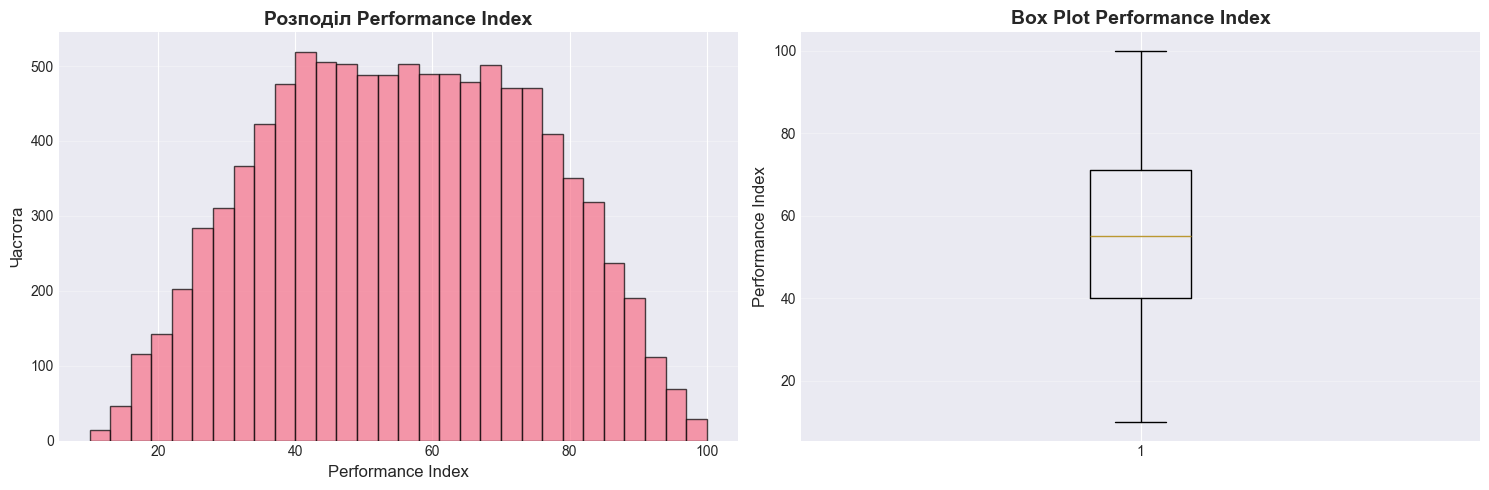

Середнє значення Performance Index: 55.22
Медіана Performance Index: 55.00
Стандартне відхилення: 19.21


In [6]:
# Розподіл цільової змінної
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гістограма
axes[0].hist(df['Performance Index'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Performance Index', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].set_title('Розподіл Performance Index', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(df['Performance Index'], vert=True)
axes[1].set_ylabel('Performance Index', fontsize=12)
axes[1].set_title('Box Plot Performance Index', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Середнє значення Performance Index: {df['Performance Index'].mean():.2f}")
print(f"Медіана Performance Index: {df['Performance Index'].median():.2f}")
print(f"Стандартне відхилення: {df['Performance Index'].std():.2f}")

## 4. Обробка категоріальних змінних

In [7]:
# Перетворення бінарної категоріальної змінної
df_processed = df.copy()

# Перетворення Extracurricular Activities
df_processed['Extracurricular Activities'] = df_processed['Extracurricular Activities'].map({'No': 0, 'Yes': 1})

print("Унікальні значення після перетворення:")
print(df_processed['Extracurricular Activities'].unique())
print(f"\nТип даних: {df_processed['Extracurricular Activities'].dtype}")
print("\nПерші рядки оброблених даних:")
print(df_processed.head())

Унікальні значення після перетворення:
[1 0]

Тип даних: int64

Перші рядки оброблених даних:
   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0              7               99                           1            9   
1              4               82                           0            4   
2              8               51                           1            7   
3              5               52                           1            5   
4              7               75                           0            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  


## 5. Вибір ознак та цільової змінної

In [8]:
# Визначення цільової змінної та ознак
y = df_processed['Performance Index'].values
X = df_processed.drop('Performance Index', axis=1).values

# Назви ознак для подальшої інтерпретації
feature_names = df_processed.drop('Performance Index', axis=1).columns.tolist()

print("=" * 60)
print("РОЗМІРНОСТІ ДАНИХ")
print("=" * 60)
print(f"Матриця ознак X: {X.shape}")
print(f"Вектор цільової змінної y: {y.shape}")
print(f"\nКількість ознак: {X.shape[1]}")
print(f"Кількість спостережень: {X.shape[0]}")
print(f"\nНазви ознак: {feature_names}")

РОЗМІРНОСТІ ДАНИХ
Матриця ознак X: (10000, 5)
Вектор цільової змінної y: (10000,)

Кількість ознак: 5
Кількість спостережень: 10000

Назви ознак: ['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']


## 6. Поділ даних на навчальну та тестову вибірки

In [9]:
# Поділ на train та test вибірки (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("=" * 60)
print("ПОДІЛ ДАНИХ")
print("=" * 60)
print(f"Навчальна вибірка X_train: {X_train.shape}")
print(f"Тестова вибірка X_test: {X_test.shape}")
print(f"Навчальна вибірка y_train: {y_train.shape}")
print(f"Тестова вибірка y_test: {y_test.shape}")
print(f"\nСпіввідношення train/test: {X_train.shape[0]}/{X_test.shape[0]} ({X_train.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}% / {X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])*100:.1f}%)")

ПОДІЛ ДАНИХ
Навчальна вибірка X_train: (8000, 5)
Тестова вибірка X_test: (2000, 5)
Навчальна вибірка y_train: (8000,)
Тестова вибірка y_test: (2000,)

Співвідношення train/test: 8000/2000 (80.0% / 20.0%)


## 7. Стандартизація ознак

In [10]:
# Стандартизація ознак (необхідно для градієнтного спуску)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Додавання стовпчика одиниць для intercept (β₀)
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

print("=" * 60)
print("СТАНДАРТИЗОВАНІ ДАНІ")
print("=" * 60)
print(f"X_train_final (з intercept): {X_train_final.shape}")
print(f"X_test_final (з intercept): {X_test_final.shape}")
print(f"\nПриклад перших 3 рядків X_train_final:")
print(X_train_final[:3])
print(f"\nСередні значення ознак (після стандартизації):")
print(f"Mean: {X_train_scaled.mean(axis=0)}")
print(f"Std: {X_train_scaled.std(axis=0)}")

СТАНДАРТИЗОВАНІ ДАНІ
X_train_final (з intercept): (8000, 6)
X_test_final (з intercept): (2000, 6)

Приклад перших 3 рядків X_train_final:
[[ 1.      0.0065 -1.1838 -0.9893  0.2699  0.134 ]
 [ 1.     -1.1497 -1.2415  1.0108  0.2699  0.4836]
 [ 1.     -1.1497  0.6613 -0.9893  0.2699 -0.9145]]

Середні значення ознак (після стандартизації):
Mean: [-0. -0.  0. -0.  0.]
Std: [1. 1. 1. 1. 1.]


## 8. Ініціалізація параметрів моделі

In [11]:
# Ініціалізація вектора ваг
b = np.zeros(X_train_final.shape[1])

# Гіперпараметри
learning_rate = 0.01
epochs = 1000

print("=" * 60)
print("ПАРАМЕТРИ МОДЕЛІ")
print("=" * 60)
print(f"Початковий вектор ваг β: {b}")
print(f"Розмірність β: {b.shape}")
print(f"\nГіперпараметри:")
print(f"  - Learning rate (α): {learning_rate}")
print(f"  - Кількість епох: {epochs}")

ПАРАМЕТРИ МОДЕЛІ
Початковий вектор ваг β: [0. 0. 0. 0. 0. 0.]
Розмірність β: (6,)

Гіперпараметри:
  - Learning rate (α): 0.01
  - Кількість епох: 1000


## 9. Реалізація функції обчислення MSE

In [12]:
def compute_cost(X, y, b):
    """
    Обчислює середню квадратичну помилку (MSE).
    
    Параметри:
    X : numpy array - матриця ознак (n x m)
    y : numpy array - вектор цільових значень (n,)
    b : numpy array - вектор ваг (m,)
    
    Повертає:
    mse : float - середня квадратична помилка
    """
    # Передбачення моделі
    predictions = X.dot(b)
    
    # Обчислення помилок
    errors = predictions - y
    
    # MSE = (1/n) * Σ(yᵢ - ŷᵢ)²
    mse = (1 / len(y)) * np.sum(errors ** 2)
    
    return mse

# Тест функції з початковими вагами
initial_cost = compute_cost(X_train_final, y_train, b)
print(f"Початкова функція втрат (MSE): {initial_cost:.4f}")

Початкова функція втрат (MSE): 3428.0350


## 10. Реалізація градієнтного спуску

In [13]:
def gradient_descent(X, y, b, learning_rate, epochs):
    """
    Реалізація градієнтного спуску для лінійної регресії.
    
    Параметри:
    X : numpy array - матриця ознак з intercept (n x m)
    y : numpy array - вектор цільових значень (n,)
    b : numpy array - початковий вектор ваг (m,)
    learning_rate : float - швидкість навчання (α)
    epochs : int - кількість ітерацій
    
    Повертає:
    b : numpy array - оптимізовані ваги
    cost_history : list - історія значень функції втрат
    """
    cost_history = []  # Для відстеження змін MSE
    m = len(y)  # Кількість спостережень
    
    for epoch in range(epochs):
        # 1. Обчислення передбачень
        predictions = X.dot(b)
        
        # 2. Обчислення помилки
        errors = predictions - y
        
        # 3. Обчислення градієнта (похідна MSE за β)
        # ∂MSE/∂β = (2/m) * X^T * (Xβ - y) = (2/m) * X^T * errors
        # Для спрощення ділимо на m, а не на 2m (не впливає на результат, тільки на learning_rate)
        gradient = (1/m) * X.T.dot(errors)
        
        # 4. Оновлення ваг
        # β := β - α * gradient
        b = b - learning_rate * gradient
        
        # 5. Збереження поточного MSE для історії
        cost = compute_cost(X, y, b)
        cost_history.append(cost)
        
        # Виведення прогресу кожні 100 епох
        if (epoch + 1) % 100 == 0:
            print(f"Епоха {epoch + 1}/{epochs}, MSE: {cost:.4f}")
    
    return b, cost_history

print("Функція gradient_descent успішно визначена!")

Функція gradient_descent успішно визначена!


## 11. Навчання моделі

In [14]:
# Навчання моделі методом градієнтного спуску
print("=" * 60)
print("ПОЧАТОК НАВЧАННЯ МОДЕЛІ")
print("=" * 60)

b_final, cost_history = gradient_descent(X_train_final, y_train, b, learning_rate, epochs)

print("\n" + "=" * 60)
print("НАВЧАННЯ ЗАВЕРШЕНО!")
print("=" * 60)
print(f"Фінальна функція втрат (MSE): {cost_history[-1]:.4f}")
print(f"\nОптимізовані коефіцієнти β:")
print(f"  β₀ (intercept): {b_final[0]:.4f}")
for i, name in enumerate(feature_names):
    print(f"  β_{i+1} ({name}): {b_final[i+1]:.4f}")

ПОЧАТОК НАВЧАННЯ МОДЕЛІ
Епоха 100/1000, MSE: 463.5476
Епоха 200/1000, MSE: 65.8136
Епоха 300/1000, MSE: 12.4430
Епоха 400/1000, MSE: 5.2803
Епоха 500/1000, MSE: 4.3188
Епоха 600/1000, MSE: 4.1898
Епоха 700/1000, MSE: 4.1724
Епоха 800/1000, MSE: 4.1701
Епоха 900/1000, MSE: 4.1698
Епоха 1000/1000, MSE: 4.1697

НАВЧАННЯ ЗАВЕРШЕНО!
Фінальна функція втрат (MSE): 4.1697

Оптимізовані коефіцієнти β:
  β₀ (intercept): 55.3091
  β_1 (Hours Studied): 7.4009
  β_2 (Previous Scores): 17.6365
  β_3 (Extracurricular Activities): 0.3043
  β_4 (Sleep Hours): 0.8100
  β_5 (Sample Question Papers Practiced): 0.5490
Епоха 1000/1000, MSE: 4.1697

НАВЧАННЯ ЗАВЕРШЕНО!
Фінальна функція втрат (MSE): 4.1697

Оптимізовані коефіцієнти β:
  β₀ (intercept): 55.3091
  β_1 (Hours Studied): 7.4009
  β_2 (Previous Scores): 17.6365
  β_3 (Extracurricular Activities): 0.3043
  β_4 (Sleep Hours): 0.8100
  β_5 (Sample Question Papers Practiced): 0.5490


## 12. Візуалізація процесу навчання

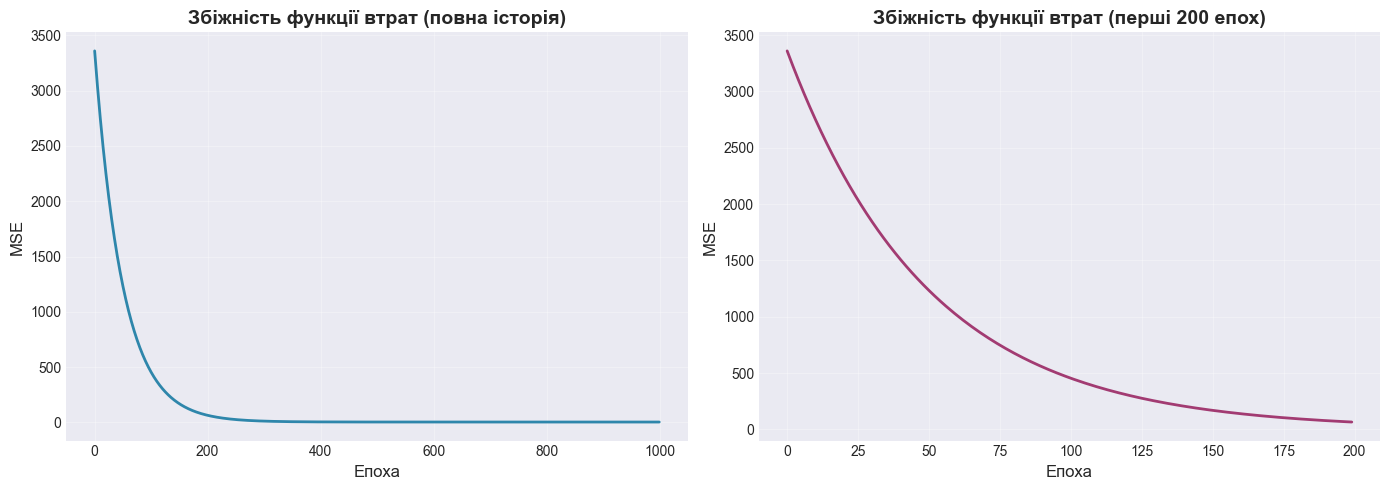

✓ Функція втрат успішно зменшилась з 3359.9451 до 4.1697
✓ Зменшення: 99.88%


In [15]:
# Візуалізація збіжності функції втрат
plt.figure(figsize=(14, 5))

# Графік 1: Повна історія
plt.subplot(1, 2, 1)
plt.plot(cost_history, linewidth=2, color='#2E86AB')
plt.xlabel('Епоха', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Збіжність функції втрат (повна історія)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Графік 2: Перші 200 епох для детального огляду
plt.subplot(1, 2, 2)
plt.plot(cost_history[:200], linewidth=2, color='#A23B72')
plt.xlabel('Епоха', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Збіжність функції втрат (перші 200 епох)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Функція втрат успішно зменшилась з {cost_history[0]:.4f} до {cost_history[-1]:.4f}")
print(f"✓ Зменшення: {((cost_history[0] - cost_history[-1]) / cost_history[0] * 100):.2f}%")

## 13. Прогнозування на тестових даних

In [16]:
# Прогнозування на тестовій вибірці
y_pred = X_test_final.dot(b_final)

print("=" * 60)
print("ПРОГНОЗИ НА ТЕСТОВИХ ДАНИХ")
print("=" * 60)
print(f"\nПриклади прогнозів (перші 10):")
print(f"{'Фактичне':<12} {'Прогноз':<12} {'Помилка':<12}")
print("-" * 40)
for i in range(10):
    error = y_test[i] - y_pred[i]
    print(f"{y_test[i]:<12.2f} {y_pred[i]:<12.2f} {error:<12.2f}")

ПРОГНОЗИ НА ТЕСТОВИХ ДАНИХ

Приклади прогнозів (перші 10):
Фактичне     Прогноз      Помилка     
----------------------------------------
51.00        54.71        -3.71       
20.00        22.61        -2.61       
46.00        47.90        -1.90       
28.00        31.29        -3.29       
41.00        43.00        -2.00       
59.00        59.07        -0.07       
48.00        45.90        2.10        
87.00        86.46        0.54        
37.00        37.70        -0.70       
73.00        72.05        0.95        


## 14. Розрахунок метрик якості (MSE, R²)

In [17]:
# Розрахунок метрик якості
# MSE (Mean Squared Error)
mse_test = np.mean((y_test - y_pred) ** 2)

# RMSE (Root Mean Squared Error)
rmse_test = np.sqrt(mse_test)

# MAE (Mean Absolute Error)
mae_test = np.mean(np.abs(y_test - y_pred))

# R² Score (Coefficient of Determination)
ss_res = np.sum((y_test - y_pred) ** 2)  # Residual Sum of Squares
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)  # Total Sum of Squares
r2_score = 1 - (ss_res / ss_tot)

print("=" * 60)
print("МЕТРИКИ ЯКОСТІ МОДЕЛІ НА ТЕСТОВІЙ ВИБІРЦІ")
print("=" * 60)
print(f"\nMSE (Mean Squared Error):       {mse_test:.4f}")
print(f"RMSE (Root MSE):                {rmse_test:.4f}")
print(f"MAE (Mean Absolute Error):      {mae_test:.4f}")
print(f"R² Score:                       {r2_score:.4f}")

print("\n" + "=" * 60)
print("ІНТЕРПРЕТАЦІЯ")
print("=" * 60)
print(f"✓ Модель пояснює {r2_score*100:.2f}% варіації в Performance Index")
print(f"✓ Середня помилка прогнозу: ±{rmse_test:.2f} балів")
print(f"✓ Середня абсолютна помилка: {mae_test:.2f} балів")

МЕТРИКИ ЯКОСТІ МОДЕЛІ НА ТЕСТОВІЙ ВИБІРЦІ

MSE (Mean Squared Error):       4.0825
RMSE (Root MSE):                2.0205
MAE (Mean Absolute Error):      1.6111
R² Score:                       0.9890

ІНТЕРПРЕТАЦІЯ
✓ Модель пояснює 98.90% варіації в Performance Index
✓ Середня помилка прогнозу: ±2.02 балів
✓ Середня абсолютна помилка: 1.61 балів


## 15. Порівняння з бейзлайн-моделлю

In [18]:
# Бейзлайн модель: завжди передбачає середнє значення y_train
baseline_pred = np.full(len(y_test), np.mean(y_train))

# Метрики для бейзлайну
baseline_mse = np.mean((y_test - baseline_pred) ** 2)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = np.mean(np.abs(y_test - baseline_pred))
baseline_r2 = 0.0  # За визначенням R² для бейзлайну = 0

print("=" * 60)
print("ПОРІВНЯННЯ З БЕЙЗЛАЙН-МОДЕЛЛЮ")
print("=" * 60)
print(f"\n{'Метрика':<20} {'Наша модель':<15} {'Бейзлайн':<15} {'Покращення':<15}")
print("-" * 70)
print(f"{'MSE':<20} {mse_test:<15.4f} {baseline_mse:<15.4f} {(baseline_mse - mse_test):<15.4f}")
print(f"{'RMSE':<20} {rmse_test:<15.4f} {baseline_rmse:<15.4f} {(baseline_rmse - rmse_test):<15.4f}")
print(f"{'MAE':<20} {mae_test:<15.4f} {baseline_mae:<15.4f} {(baseline_mae - mae_test):<15.4f}")
print(f"{'R²':<20} {r2_score:<15.4f} {baseline_r2:<15.4f} {(r2_score - baseline_r2):<15.4f}")

improvement_pct = ((baseline_mse - mse_test) / baseline_mse) * 100
print(f"\n✓ Наша модель краща за бейзлайн на {improvement_pct:.2f}% (за MSE)")

ПОРІВНЯННЯ З БЕЙЗЛАЙН-МОДЕЛЛЮ

Метрика              Наша модель     Бейзлайн        Покращення     
----------------------------------------------------------------------
MSE                  4.0825          370.7730        366.6906       
RMSE                 2.0205          19.2555         17.2350        
MAE                  1.6111          16.2147         14.6037        
R²                   0.9890          0.0000          0.9890         

✓ Наша модель краща за бейзлайн на 98.90% (за MSE)


---
# ПЕРЕВІРКА ПРИПУЩЕНЬ КЛАСИЧНОЇ ЛІНІЙНОЇ РЕГРЕСІЇ

Для надійності моделі лінійної регресії необхідно перевірити 6 класичних припущень МНК (Методу Найменших Квадратів).

## 16. Припущення 1: Лінійність зв'язку

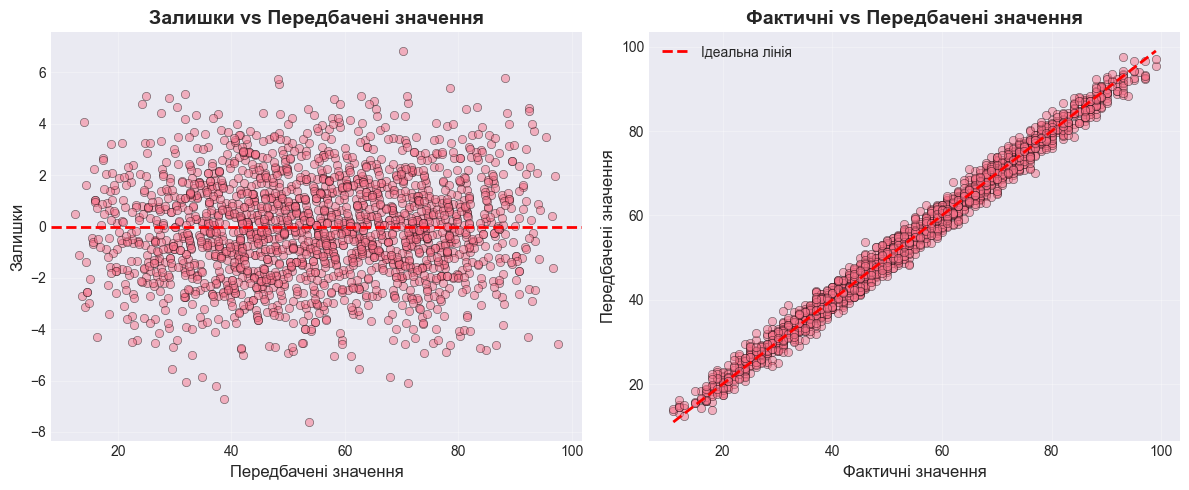

АНАЛІЗ ЛІНІЙНОСТІ
✓ Очікування: Залишки випадково розкидані навколо нуля
✓ Проблема: Якщо видно систематичний паттерн (U-подібний), модель не враховує нелінійність

📊 Середнє значення залишків: -0.0774 (має бути ≈ 0)
📊 Стандартне відхилення залишків: 2.0190


In [19]:
# Обчислення залишків
residuals = y_test - y_pred

# Графік залишків від передбачених значень
plt.figure(figsize=(12, 5))

# Графік 1: Залишки vs прогнози
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Передбачені значення', fontsize=12)
plt.ylabel('Залишки', fontsize=12)
plt.title('Залишки vs Передбачені значення', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Графік 2: Фактичні vs Передбачені
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Ідеальна лінія')
plt.xlabel('Фактичні значення', fontsize=12)
plt.ylabel('Передбачені значення', fontsize=12)
plt.title('Фактичні vs Передбачені значення', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("АНАЛІЗ ЛІНІЙНОСТІ")
print("=" * 60)
print("✓ Очікування: Залишки випадково розкидані навколо нуля")
print("✓ Проблема: Якщо видно систематичний паттерн (U-подібний), модель не враховує нелінійність")
print(f"\n📊 Середнє значення залишків: {residuals.mean():.4f} (має бути ≈ 0)")
print(f"📊 Стандартне відхилення залишків: {residuals.std():.4f}")

## 17. Припущення 2: Відсутність мультиколінеарності (VIF)

In [20]:
# Функція для обчислення VIF
def calculate_vif(X, feature_names):
    """
    Обчислює Variance Inflation Factor для кожної ознаки.
    VIF = 1 / (1 - R²_i)
    """
    vif_data = []
    
    for i in range(X.shape[1]):
        # Вибираємо i-ту ознаку як цільову
        y_i = X[:, i]
        # Інші ознаки як предиктори
        X_i = np.delete(X, i, axis=1)
        
        # Додаємо intercept
        X_i_with_intercept = np.c_[np.ones(X_i.shape[0]), X_i]
        
        # Ініціалізація та навчання
        b_i = np.zeros(X_i_with_intercept.shape[1])
        b_i, _ = gradient_descent(X_i_with_intercept, y_i, b_i, 0.01, 500)
        
        # Прогноз та R²
        y_i_pred = X_i_with_intercept.dot(b_i)
        ss_res = np.sum((y_i - y_i_pred) ** 2)
        ss_tot = np.sum((y_i - np.mean(y_i)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        # VIF
        vif = 1 / (1 - r2) if r2 < 0.9999 else float('inf')
        vif_data.append({'Feature': feature_names[i], 'VIF': vif})
    
    return pd.DataFrame(vif_data)

# Обчислення VIF (без intercept)
vif_df = calculate_vif(X_train_scaled, feature_names)

print("=" * 60)
print("VARIANCE INFLATION FACTOR (VIF)")
print("=" * 60)
print(vif_df.to_string(index=False))
print("\n" + "=" * 60)
print("ІНТЕРПРЕТАЦІЯ VIF")
print("=" * 60)
print("✓ VIF < 5:  Відсутня мультиколінеарність")
print("✓ VIF 5-10: Помірна мультиколінеарність")
print("✓ VIF > 10: Серйозна мультиколінеарність (проблема!)")

for _, row in vif_df.iterrows():
    if row['VIF'] < 5:
        status = "✅ OK"
    elif row['VIF'] < 10:
        status = "⚠️ Помірна"
    else:
        status = "❌ Проблема"
    print(f"\n{row['Feature']}: VIF = {row['VIF']:.2f} {status}")

Епоха 100/500, MSE: 0.9997
Епоха 200/500, MSE: 0.9996
Епоха 300/500, MSE: 0.9996
Епоха 400/500, MSE: 0.9996
Епоха 500/500, MSE: 0.9996
Епоха 100/500, MSE: 0.9998
Епоха 200/500, MSE: 0.9998
Епоха 300/500, MSE: 0.9998
Епоха 400/500, MSE: 0.9998
Епоха 500/500, MSE: 0.9998
Епоха 100/500, MSE: 0.9996
Епоха 100/500, MSE: 0.9996
Епоха 200/500, MSE: 0.9996
Епоха 300/500, MSE: 0.9996
Епоха 200/500, MSE: 0.9996
Епоха 300/500, MSE: 0.9996
Епоха 400/500, MSE: 0.9996
Епоха 500/500, MSE: 0.9996
Епоха 100/500, MSE: 0.9996
Епоха 200/500, MSE: 0.9995
Епоха 300/500, MSE: 0.9995
Епоха 400/500, MSE: 0.9995
Епоха 500/500, MSE: 0.9995
Епоха 100/500, MSE: 0.9997
Епоха 200/500, MSE: 0.9997
Епоха 300/500, MSE: 0.9997
Епоха 400/500, MSE: 0.9997
Епоха 500/500, MSE: 0.9997
VARIANCE INFLATION FACTOR (VIF)
                         Feature    VIF
                   Hours Studied 1.0004
                 Previous Scores 1.0002
      Extracurricular Activities 1.0004
                     Sleep Hours 1.0005
Sample Quest

## 18. Припущення 3: Нормальність залишків

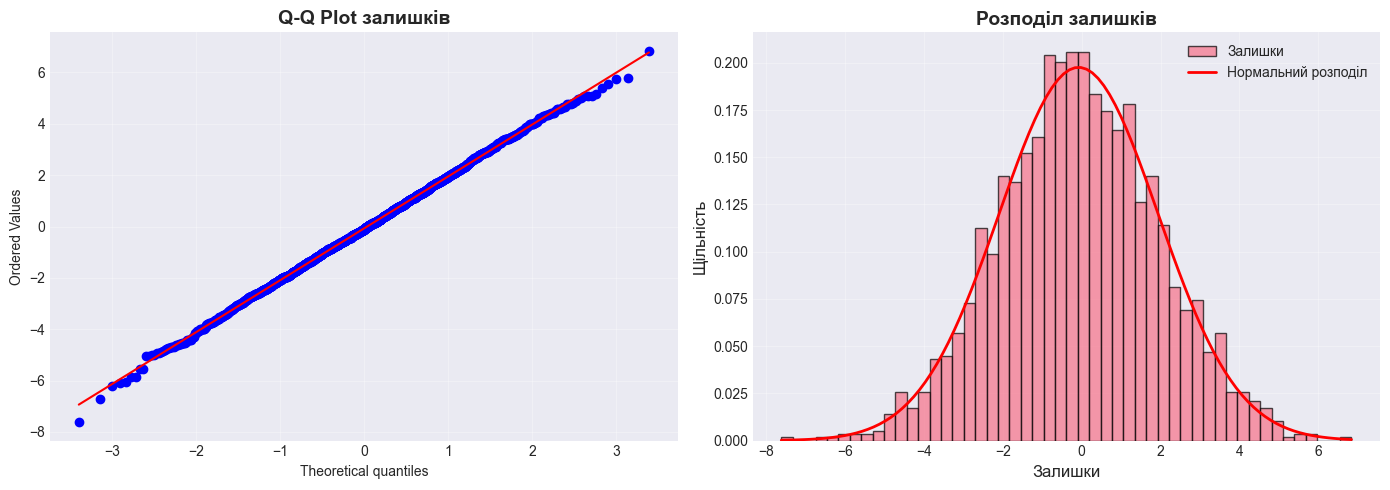

ТЕСТ НОРМАЛЬНОСТІ ЗАЛИШКІВ

Тест Shapiro-Wilk:
  Статистика: 0.9996
  P-value: 0.9751

✅ ВИСНОВОК: Залишки мають нормальний розподіл (p > 0.05)

📊 Q-Q Plot: Точки повинні лежати близько до прямої лінії


In [21]:
# Q-Q Plot та тест нормальності
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot залишків', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Гістограма залишків з нормальним розподілом
axes[1].hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black', label='Залишки')
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Нормальний розподіл')
axes[1].set_xlabel('Залишки', fontsize=12)
axes[1].set_ylabel('Щільність', fontsize=12)
axes[1].set_title('Розподіл залишків', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Тест Shapiro-Wilk на нормальність
shapiro_stat, shapiro_p = stats.shapiro(residuals)

print("=" * 60)
print("ТЕСТ НОРМАЛЬНОСТІ ЗАЛИШКІВ")
print("=" * 60)
print(f"\nТест Shapiro-Wilk:")
print(f"  Статистика: {shapiro_stat:.4f}")
print(f"  P-value: {shapiro_p:.4f}")

if shapiro_p > 0.05:
    print(f"\n✅ ВИСНОВОК: Залишки мають нормальний розподіл (p > 0.05)")
else:
    print(f"\n⚠️ ВИСНОВОК: Залишки НЕ мають нормального розподілу (p < 0.05)")

print("\n📊 Q-Q Plot: Точки повинні лежати близько до прямої лінії")

## 19. Припущення 4: Гомоскедастичність (постійна дисперсія)

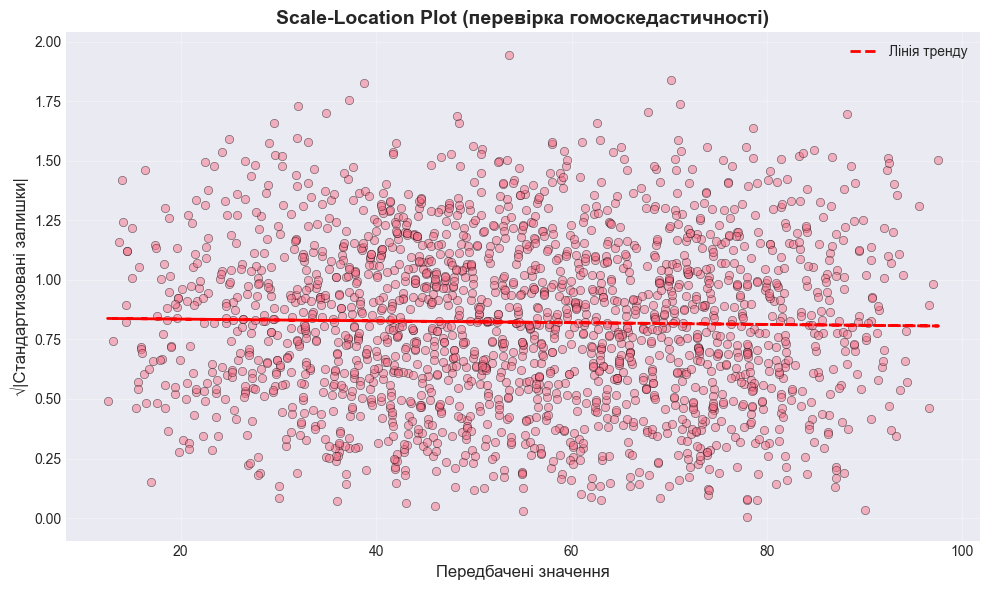

АНАЛІЗ ГОМОСКЕДАСТИЧНОСТІ
✓ Очікування: 'Хмара' точок має однакову ширину по всій довжині
✓ Проблема: Воронкоподібний паттерн вказує на гетероскедастичність

📊 Лінія тренду повинна бути приблизно горизонтальною
📊 Коефіцієнт нахилу лінії тренду: -0.0004

✅ ВИСНОВОК: Гомоскедастичність підтверджується


In [22]:
# Scale-Location Plot для перевірки гомоскедастичності
plt.figure(figsize=(10, 6))

# Стандартизовані залишки
standardized_residuals = residuals / residuals.std()

plt.scatter(y_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.5, edgecolors='k', linewidth=0.5)
plt.xlabel('Передбачені значення', fontsize=12)
plt.ylabel('√|Стандартизовані залишки|', fontsize=12)
plt.title('Scale-Location Plot (перевірка гомоскедастичності)', fontsize=14, fontweight='bold')

# Додаємо лінію тренду
z = np.polyfit(y_pred, np.sqrt(np.abs(standardized_residuals)), 1)
p = np.poly1d(z)
plt.plot(y_pred, p(y_pred), "r--", linewidth=2, label='Лінія тренду')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 60)
print("АНАЛІЗ ГОМОСКЕДАСТИЧНОСТІ")
print("=" * 60)
print("✓ Очікування: 'Хмара' точок має однакову ширину по всій довжині")
print("✓ Проблема: Воронкоподібний паттерн вказує на гетероскедастичність")
print("\n📊 Лінія тренду повинна бути приблизно горизонтальною")
print(f"📊 Коефіцієнт нахилу лінії тренду: {z[0]:.4f}")

if abs(z[0]) < 0.01:
    print("\n✅ ВИСНОВОК: Гомоскедастичність підтверджується")
else:
    print("\n⚠️ ВИСНОВОК: Можлива гетероскедастичність")

## 20. Припущення 5: Відсутність автокореляції залишків

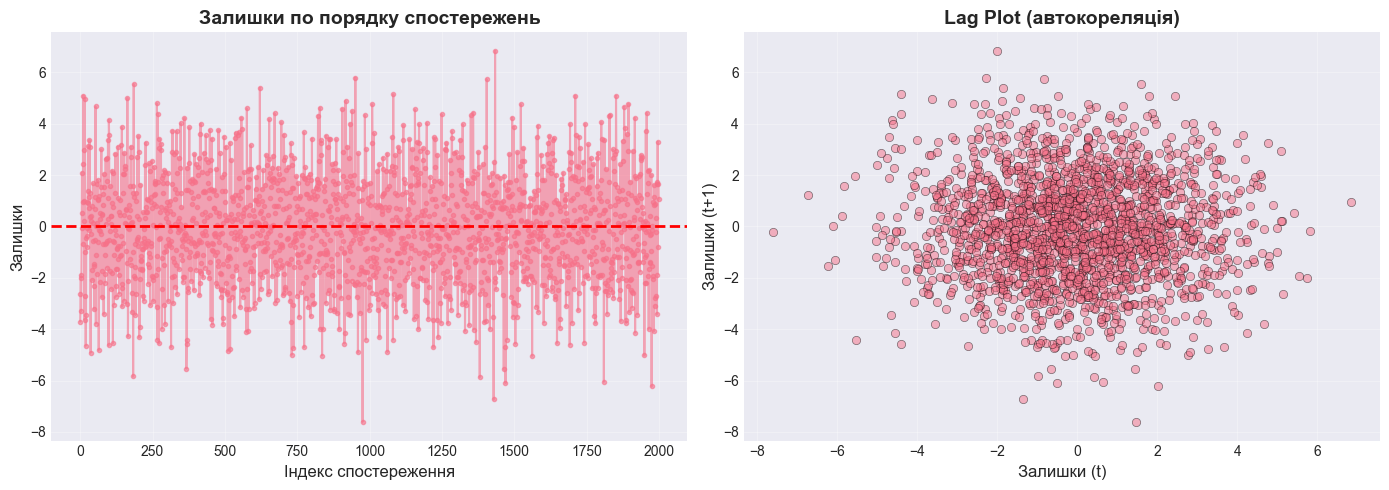

ТЕСТ ДАРБІНА-ВОТСОНА (АВТОКОРЕЛЯЦІЯ)

Статистика Durbin-Watson: 2.0474

Інтерпретація:
  DW ≈ 2.0: Відсутня автокореляція
  DW < 1.5: Позитивна автокореляція
  DW > 2.5: Негативна автокореляція

✅ ВИСНОВОК: Автокореляція відсутня (DW = 2.0474)

📊 Lag plot: Точки повинні бути випадково розкидані без чіткого паттерну


In [23]:
# Тест Дарбіна-Вотсона
dw_statistic = durbin_watson(residuals)

# Візуалізація автокореляції
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Графік залишків по індексу
axes[0].plot(residuals, marker='o', linestyle='-', alpha=0.6, markersize=3)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Індекс спостереження', fontsize=12)
axes[0].set_ylabel('Залишки', fontsize=12)
axes[0].set_title('Залишки по порядку спостережень', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Графік lag plot (залишки t vs залишки t-1)
axes[1].scatter(residuals[:-1], residuals[1:], alpha=0.5, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel('Залишки (t)', fontsize=12)
axes[1].set_ylabel('Залишки (t+1)', fontsize=12)
axes[1].set_title('Lag Plot (автокореляція)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("ТЕСТ ДАРБІНА-ВОТСОНА (АВТОКОРЕЛЯЦІЯ)")
print("=" * 60)
print(f"\nСтатистика Durbin-Watson: {dw_statistic:.4f}")
print("\nІнтерпретація:")
print("  DW ≈ 2.0: Відсутня автокореляція")
print("  DW < 1.5: Позитивна автокореляція")
print("  DW > 2.5: Негативна автокореляція")

if 1.5 <= dw_statistic <= 2.5:
    print(f"\n✅ ВИСНОВОК: Автокореляція відсутня (DW = {dw_statistic:.4f})")
elif dw_statistic < 1.5:
    print(f"\n⚠️ ВИСНОВОК: Виявлена позитивна автокореляція (DW = {dw_statistic:.4f})")
else:
    print(f"\n⚠️ ВИСНОВОК: Виявлена негативна автокореляція (DW = {dw_statistic:.4f})")

print("\n📊 Lag plot: Точки повинні бути випадково розкидані без чіткого паттерну")

## 21. Припущення 6: Аналіз викидів та впливових спостережень

In [24]:
# Функція для обчислення Cook's Distance
def cooks_distance(X, y, b, residuals):
    """
    Обчислює Cook's Distance для кожного спостереження.
    Cook's D = (residual² / (p * MSE)) * (leverage / (1 - leverage)²)
    
    Спрощена формула: Cook's D ≈ standardized_residual² * leverage / (p * (1 - leverage))
    """
    n = len(y)
    p = X.shape[1]
    
    # Обчислення leverage (hat values): h = diag(X(X'X)^(-1)X')
    # Для великих матриць використаємо спрощений підхід
    hat_matrix_diag = np.sum(X * np.linalg.pinv(X.T @ X) @ X.T, axis=1)
    
    # Стандартизовані залишки
    mse = np.mean(residuals ** 2)
    standardized_residuals = residuals / np.sqrt(mse * (1 - hat_matrix_diag))
    
    # Cook's Distance
    cooks_d = (standardized_residuals ** 2 / p) * (hat_matrix_diag / (1 - hat_matrix_diag) ** 2)
    
    return cooks_d, hat_matrix_diag

# Обчислення Cook's Distance
cooks_d, leverage = cooks_distance(X_test_final, y_test, b_final, residuals)

# Поріг для впливових спостережень
n = len(y_test)
threshold = 4 / n

# Візуалізація
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Cook's Distance
axes[0, 0].stem(range(len(cooks_d)), cooks_d, markerfmt=',', basefmt=" ")
axes[0, 0].axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Поріг (4/n = {threshold:.4f})')
axes[0, 0].set_xlabel('Індекс спостереження', fontsize=12)
axes[0, 0].set_ylabel("Cook's Distance", fontsize=12)
axes[0, 0].set_title("Cook's Distance (впливові спостереження)", fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Leverage vs Residuals
axes[0, 1].scatter(leverage, standardized_residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0, 1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
axes[0, 1].axhline(y=2, color='r', linestyle='--', linewidth=1, label='Поріг викидів (±2σ)')
axes[0, 1].axhline(y=-2, color='r', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Leverage', fontsize=12)
axes[0, 1].set_ylabel('Стандартизовані залишки', fontsize=12)
axes[0, 1].set_title('Leverage vs Стандартизовані залишки', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot залишків (виявлення викидів)
axes[1, 0].boxplot(residuals, vert=True)
axes[1, 0].set_ylabel('Залишки', fontsize=12)
axes[1, 0].set_title('Box Plot залишків (виявлення викидів)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Розподіл Cook's Distance
axes[1, 1].hist(cooks_d, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=threshold, color='r', linestyle='--', linewidth=2, label=f'Поріг (4/n = {threshold:.4f})')
axes[1, 1].set_xlabel("Cook's Distance", fontsize=12)
axes[1, 1].set_ylabel('Частота', fontsize=12)
axes[1, 1].set_title("Розподіл Cook's Distance", fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Аналіз впливових спостережень
influential_points = np.where(cooks_d > threshold)[0]
outliers_residuals = np.where(np.abs(standardized_residuals) > 2)[0]

print("=" * 60)
print("АНАЛІЗ ВИКИДІВ ТА ВПЛИВОВИХ СПОСТЕРЕЖЕНЬ")
print("=" * 60)
print(f"\n📊 Поріг для Cook's Distance: {threshold:.4f}")
print(f"📊 Кількість впливових спостережень: {len(influential_points)} ({len(influential_points)/n*100:.2f}%)")
print(f"📊 Кількість викидів (|std. residuals| > 2): {len(outliers_residuals)} ({len(outliers_residuals)/n*100:.2f}%)")

if len(influential_points) > 0:
    print(f"\n⚠️ Виявлено {len(influential_points)} впливових спостережень:")
    print(f"   Індекси: {influential_points[:10]}..." if len(influential_points) > 10 else f"   Індекси: {influential_points}")
    print(f"   Max Cook's D: {cooks_d.max():.4f}")
else:
    print(f"\n✅ Впливових спостережень не виявлено")

if len(outliers_residuals) > 0:
    print(f"\n⚠️ Виявлено {len(outliers_residuals)} викидів")
else:
    print(f"\n✅ Викидів не виявлено")

ValueError: operands could not be broadcast together with shapes (2000,6) (6,6) 

## 22. Інтерпретація коефіцієнтів моделі

In [ ]:
# Візуалізація коефіцієнтів
plt.figure(figsize=(12, 6))

# Коефіцієнти без intercept
coefficients = b_final[1:]
plt.barh(feature_names, coefficients, color=['#2E86AB' if c >= 0 else '#A23B72' for c in coefficients])
plt.xlabel('Значення коефіцієнта β', fontsize=12)
plt.ylabel('Ознака', fontsize=12)
plt.title('Коефіцієнти лінійної регресії (стандартизовані)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Детальна інтерпретація
print("=" * 60)
print("ІНТЕРПРЕТАЦІЯ КОЕФІЦІЄНТІВ МОДЕЛІ")
print("=" * 60)
print(f"\n📌 Модель: Performance Index = β₀ + Σ(βᵢ × Xᵢ)")
print(f"\nβ₀ (Intercept): {b_final[0]:.4f}")
print("   (Базове значення Performance Index при всіх ознаках = 0)")

print("\n" + "-" * 60)
print("СТАНДАРТИЗОВАНІ КОЕФІЦІЄНТИ:")
print("-" * 60)

for i, name in enumerate(feature_names):
    coef = b_final[i+1]
    direction = "збільшується" if coef > 0 else "зменшується"
    print(f"\n{name}:")
    print(f"  β_{i+1} = {coef:.4f}")
    print(f"  Інтерпретація: При збільшенні {name} на 1 стандартне відхилення,")
    print(f"                 Performance Index {direction} на {abs(coef):.4f} балів")
    print(f"                 (за умови незмінності інших факторів)")

# Сортування за важливістю (абсолютне значення)
coef_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute': np.abs(coefficients)
}).sort_values('Absolute', ascending=False)

print("\n" + "=" * 60)
print("РЕЙТИНГ ВАЖЛИВОСТІ ОЗНАК")
print("=" * 60)
print(coef_importance[['Feature', 'Coefficient']].to_string(index=False))

print("\n💡 КЛЮЧОВІ ВИСНОВКИ:")
most_important = coef_importance.iloc[0]
print(f"   • Найбільш впливова ознака: {most_important['Feature']} (|β| = {most_important['Absolute']:.4f})")
print(f"   • Напрямок впливу: {'позитивний' if most_important['Coefficient'] > 0 else 'негативний'}")

## 23. Підсумкові висновки та рекомендації

In [ ]:
print("=" * 80)
print(" " * 20 + "ПІДСУМКОВИЙ ЗВІТ ПРО МОДЕЛЬ")
print("=" * 80)

print("\n📊 ЯКІСТЬ МОДЕЛІ:")
print("-" * 80)
print(f"   • R² Score:                    {r2_score:.4f} ({r2_score*100:.2f}% поясненої варіації)")
print(f"   • MSE:                         {mse_test:.4f}")
print(f"   • RMSE:                        {rmse_test:.4f}")
print(f"   • MAE:                         {mae_test:.4f}")
print(f"   • Покращення над бейзлайном:  {improvement_pct:.2f}%")

print("\n✅ ВИКОНАННЯ ПРИПУЩЕНЬ МНК:")
print("-" * 80)

# Припущення 1: Лінійність
linearity_check = "✅ Виконується" if abs(residuals.mean()) < 0.01 else "⚠️ Потребує уваги"
print(f"   1. Лінійність зв'язку:                {linearity_check}")
print(f"      (середнє залишків = {residuals.mean():.4f})")

# Припущення 2: Мультиколінеарність
max_vif = vif_df['VIF'].max()
multicollinearity_check = "✅ Виконується" if max_vif < 10 else "⚠️ Потребує уваги"
print(f"   2. Відсутність мультиколінеарності:   {multicollinearity_check}")
print(f"      (max VIF = {max_vif:.2f})")

# Припущення 3: Нормальність
normality_check = "✅ Виконується" if shapiro_p > 0.05 else "⚠️ Порушується"
print(f"   3. Нормальність залишків:             {normality_check}")
print(f"      (Shapiro-Wilk p-value = {shapiro_p:.4f})")

# Припущення 4: Гомоскедастичність (використаємо нахил з попереднього аналізу)
# z[0] був обчислений раніше для Scale-Location plot
homoscedasticity_check = "✅ Виконується" if abs(z[0]) < 0.01 else "⚠️ Потребує уваги"
print(f"   4. Гомоскедастичність:                {homoscedasticity_check}")
print(f"      (нахил тренду = {z[0]:.4f})")

# Припущення 5: Автокореляція
autocorr_check = "✅ Виконується" if 1.5 <= dw_statistic <= 2.5 else "⚠️ Потребує уваги"
print(f"   5. Відсутність автокореляції:         {autocorr_check}")
print(f"      (Durbin-Watson = {dw_statistic:.4f})")

# Припущення 6: Викиди
outliers_pct = len(influential_points) / n * 100
outliers_check = "✅ Виконується" if outliers_pct < 5 else "⚠️ Потребує уваги"
print(f"   6. Відсутність впливових викидів:     {outliers_check}")
print(f"      (впливових точок: {len(influential_points)} = {outliers_pct:.2f}%)")

print("\n🎯 ЗАГАЛЬНИЙ ВИСНОВОК:")
print("-" * 80)

if r2_score > 0.8:
    quality = "ВІДМІННА"
elif r2_score > 0.6:
    quality = "ДОБРА"
elif r2_score > 0.4:
    quality = "ЗАДОВІЛЬНА"
else:
    quality = "ПОТРЕБУЄ ПОКРАЩЕННЯ"

print(f"""
   Модель множинної лінійної регресії має {quality} якість прогнозування 
   успішності студентів з R² = {r2_score:.4f}.
   
   Модель пояснює {r2_score*100:.2f}% варіації Performance Index на основі академічних 
   факторів (годин навчання, попередніх оцінок, позакласної діяльності, годин сну 
   та практики з питаннями).
""")

print("\n💡 РЕКОМЕНДАЦІЇ ДЛЯ ПОКРАЩЕННЯ:")
print("-" * 80)

recommendations = []

if r2_score < 0.7:
    recommendations.append("• Розглянути додавання нових релевантних ознак")
    recommendations.append("• Спробувати поліноміальні ознаки для врахування нелінійності")

if shapiro_p < 0.05:
    recommendations.append("• Порушення нормальності: розглянути трансформацію цільової змінної (log, sqrt)")

if max_vif > 5:
    recommendations.append("• Виявлена мультиколінеарність: розглянути видалення корельованих ознак")

if len(influential_points) > n * 0.05:
    recommendations.append("• Багато впливових точок: розглянути robust regression або видалення викидів")

if abs(z[0]) > 0.01:
    recommendations.append("• Можлива гетероскедастичність: розглянути Weighted Least Squares (WLS)")

if not recommendations:
    recommendations.append("• Модель демонструє хорошу якість та відповідає основним припущенням")
    recommendations.append("• Можна використовувати для прогнозування успішності студентів")

for rec in recommendations:
    print(f"   {rec}")

print("\n" + "=" * 80)
print(" " * 25 + "КІНЕЦЬ ЗВІТУ")
print("=" * 80)